In [1]:
from src.testscript import test_function, test_function2, test_function3
from src.deterministic_behavior import set_seeds
# run pip install -e . to install src
test_function()
test_function2()
test_function3()


test_function can be readily called from the scripts directory!
test_function2 can be readily called from the scripts directory!
test_function3 can be readily called from the scripts directory!


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
    ])

transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='../data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True,
                                          num_workers=2)

In [4]:
dataiter = iter(data_loader)
images, labels = dataiter.next()
print(torch.min(images), torch.max(images))
images.shape



tensor(0.) tensor(1.)


torch.Size([64, 1, 28, 28])

torch.Size([1, 28, 28])


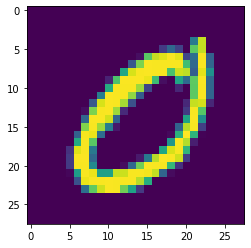

In [5]:

image_ex = images[0,:]
print(image_ex.shape)
plt.imshow(image_ex[0,:])




torch.Size([1, 784])
torch.Size([1, 392])
torch.Size([1, 392])
torch.Size([1, 784])
torch.Size([28, 28])


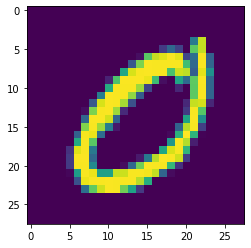

In [6]:

image_ex_reshaped = image_ex.reshape(-1,28*28)
print(image_ex_reshaped.shape)
image_ex_part1 = image_ex_reshaped[:,:28*28//2]
print(image_ex_part1.shape)
image_ex_part2 = image_ex_reshaped[:,28*28//2:]
print(image_ex_part2.shape)

image_ex_reconstructed_oned = torch.cat((image_ex_part1,image_ex_part2), 1)
print(image_ex_reconstructed_oned.shape)
image_ex_reconstructed = image_ex_reconstructed_oned.reshape(28,28)
print(image_ex_reconstructed.shape)
plt.imshow(image_ex_reconstructed)



In [10]:
image_ex.device

device(type='cpu')

In [7]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
# device = torch.device("cpu")


cuda:1


In [8]:
# repeatedly reduce the size
# TODO move to src models. Repeat analysis with pca as well.
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), # (N, 784) -> (N, 128)
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 5) # -> N, 10
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(5, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

class JointAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder1 = nn.Sequential(
            nn.Linear(28 * 28//2, 128), # (N, 784) -> (N, 128)
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 10) # -> N, 3
        )
        
        self.decoder1 = nn.Sequential(
            nn.Linear(10, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28//2),
            nn.Sigmoid()
        )

        self.encoder2 = nn.Sequential(
            nn.Linear(28 * 28//2, 128), # (N, 784) -> (N, 128)
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 10) # -> N, 3
        )
        
        self.decoder2 = nn.Sequential(
            nn.Linear(10, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28//2),
            nn.Sigmoid()
        )
    def forward(self, x):
        # TODO this is a work in progress!
        #train_size = int(0.8 * len(full_dataset))
        #test_size = len(full_dataset) - train_size
       # train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])  
        
        # # scrambled_channels = np.random.choice(np.arange(data_dim),data_dim,replace=False)
        # # TODO make this a new function - channel splitter. src/models.py
        # scrambled_channels = torch.randperm(x.shape[1])

        # # print(f"scrambled channels: {scrambled_channels}")
        # # print(f"scrambled channels shape: {scrambled_channels.shape}")
        # channels1 = scrambled_channels[:len(scrambled_channels)//2]
        # channels2 = scrambled_channels[len(scrambled_channels)//2:]

        # encoded1 = self.encoder1(x[:,channels1])
        # decoded1 = self.decoder1(encoded1)

        # encoded2 = self.encoder2(x[:,channels2])
        # decoded2 = self.decoder1(encoded2)

        # decoded_scrambled = torch.cat((decoded1,decoded2), 1)
        # idx_sorted = torch.argsort(scrambled_channels)
        # decoded = decoded_scrambled[:,idx_sorted]


        # Just splitting the channels into two
        x1 = x[:,:28*28//2]
        x2 = x[:,28*28//2:]
        encoded1 = self.encoder1(x1)
        decoded1 = self.decoder1(encoded1)

        encoded2 = self.encoder2(x2)
        decoded2 = self.decoder1(encoded2)

        decoded = torch.cat((decoded1,decoded2), 1)

        return encoded1, encoded2, decoded
    
# Input [-1, +1] -> use nn.Tanh

Epoch:1, Loss:0.0492
Epoch:2, Loss:0.0436
Epoch:3, Loss:0.0344
Epoch:4, Loss:0.0338
Epoch:5, Loss:0.0346
Epoch:6, Loss:0.0332
Epoch:7, Loss:0.0298
Epoch:8, Loss:0.0330
Epoch:9, Loss:0.0288
Epoch:10, Loss:0.0270


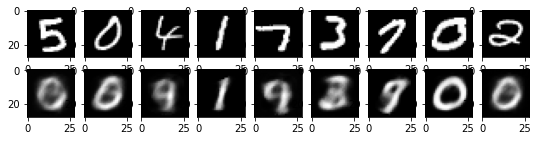

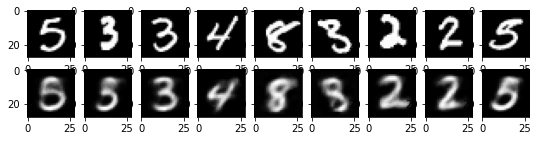

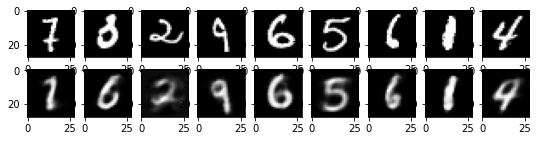

In [9]:
model = Autoencoder()
model = model.to(device) #send weights to gpu before defining optimizer
model.train() #tell network it's in training mode for things like dropout
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

# Point to training loop video
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        img.to(device)
        recon = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.title("AE")    
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

In [ ]:
model = JointAutoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

# Point to training loop video
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        img = img.to(device)
        img = img.reshape(-1, 28*28)
        latent1, latent2, recon = model(img)
        latents_loss = criterion(latent1, latent2)
        reconstruction_loss = criterion(recon, img)
        loss = latents_loss + reconstruction_loss
        loss = reconstruction_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, LatentsLoss:{latents_loss.item():.4f}, ReconsLoss:{reconstruction_loss.item():.4f}, TotalLoss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.title("JAE")    
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])